  0%|          | 0/1011893601 [00:00<?, ?it/s]

Extracting ./data/NMNIST/train.zip to ./data/NMNIST
[( 8, 16,   4231, 1) ( 9, 16,   6817, 1) (19, 16,   8789, 0) ...
 (15, 18, 303482, 1) (18,  3, 305393, 1) (21, 25, 306195, 1)]


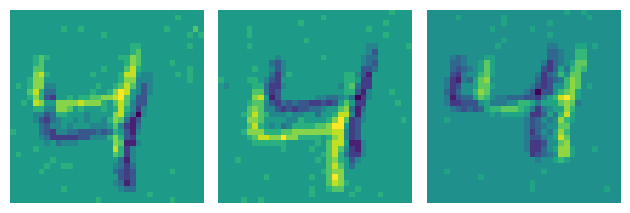

In [1]:
# pip install tonic
# pip install snntorch


#  Using Tonic to Load Neuromorphic Datasets

import tonic

dataset = tonic.datasets.NMNIST(save_to='./data', train=True)
events, target = dataset[0]


# Each row corresponds to a single event, which consists of four parameters: (x-coordinate, y-coordinate, timestamp, polarity).
print(events)


tonic.utils.plot_event_grid(events)



In [2]:
# However, neural nets don’t take lists of events as input. 
# The raw data must be converted into a suitable representation, such as a tensor. 
# We can choose a set of transforms to apply to our data before feeding it to our network. 
# The neuromorphic camera sensor has a temporal resolution of microseconds, which when converted into a dense representation, 
# ends up as a very large tensor. 
# That is why we bin events into a smaller number of frames using the ToFrame transformation, 
# which reduces temporal precision but also allows us to work with it in a dense format.


import tonic.transforms as transforms
import tonic

sensor_size = tonic.datasets.NMNIST.sensor_size

# Denoise removes isolated, one-off events
# time_window
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000),
                                      transforms.ToFrame(sensor_size=sensor_size,
                                                         time_window=1000)
                                     ])

trainset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=False)



from torch.utils.data import DataLoader
from tonic import DiskCachedDataset

cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/nmnist/train')
cached_dataloader = DataLoader(cached_trainset)

# even faster (more RAM required)
# from tonic import MemoryCachedDataset

# cached_trainset = MemoryCachedDataset(trainset)


batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())

def load_sample_batched():
    events, target = next(iter(cached_dataloader))
    
%timeit -o -r 10 load_sample_batched()


events, target = trainset[0]
# Each row corresponds to a single event, which consists of four parameters: (x-coordinate, y-coordinate, timestamp, polarity).
print(events)

tonic.utils.plot_event_grid(events)



4.31 ms ± 141 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


<TimeitResult : 4.31 ms ± 141 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)>

In [30]:
# training a network on the N-MNIST classification task

# Now let’s actually train a network on the N-MNIST classification task. 
# We start by defining our caching wrappers and dataloaders. 
# While doing that, we’re also going to apply some augmentations to the training data. 
# The samples we receive from the cached dataset are frames, 
# so we can make use of PyTorch Vision to apply whatever random transform we would like.


import torch
import torchvision

transform = tonic.transforms.Compose([torch.from_numpy,
                                      torchvision.transforms.RandomRotation([-10,10])])

cached_trainset = DiskCachedDataset(trainset, transform=transform, cache_path='./cache/nmnist/train')

# no augmentations for the testset
cached_testset = DiskCachedDataset(testset, cache_path='./cache/nmnist/test')

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)

# A mini-batch now has the dimensions (time steps, batch size, channels, height, width). 
# The number of time steps will be set to that of the longest recording in the mini-batch, 
# and all other samples will be padded with zeros to match it.

event_tensor, target = next(iter(trainloader))

print(event_tensor.shape)

torch.Size([311, 128, 2, 34, 34])


In [4]:
# Defining our network

# We will use snnTorch + PyTorch to construct a CSNN, just as in the previous tutorial. 
# The convolutional network architecture to be used is: 12C5-MP2-32C5-MP2-800FC10

# 12C5 is a 5x5 convolutional kernel with 12 filters

# MP2 is a 2x2 max-pooling function

# 800FC10 is a fully-connected layer that maps 800 neurons to 10 outputs

import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

#  Initialize Network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 32, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

# this time, we won't return membrane as we don't need it

def forward_pass(net, data):
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(data.size(0)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)

  return torch.stack(spk_rec)

# Cross Entropy Loss can be applied to the total spike count to maximize the number of spikes from the correct class.
# Another option from the snn.functional module is to specify the target number of spikes from correct and incorrect classes. 
# The approach below uses the Mean Square Error Spike Count Loss, 
# which aims to elicit spikes from the correct class 80% of the time, and 20% of the time from incorrect classes.
# Encouraging incorrect neurons to fire could be motivated to avoid dead neurons.


optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)



num_epochs = 2

loss_hist = []
acc_hist = []

In [34]:
# training loop
from IPython.display import clear_output

num_iters = 100

for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        clear_output(wait=True)  # This will clear the output of the cell where the function is called

        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())


        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}, Accuracy: {acc * 100:.2f}%\n", end="\r\r\r")

        # training loop breaks after num_iters iterations
        if i == num_iters:
          break
      


KeyboardInterrupt: 

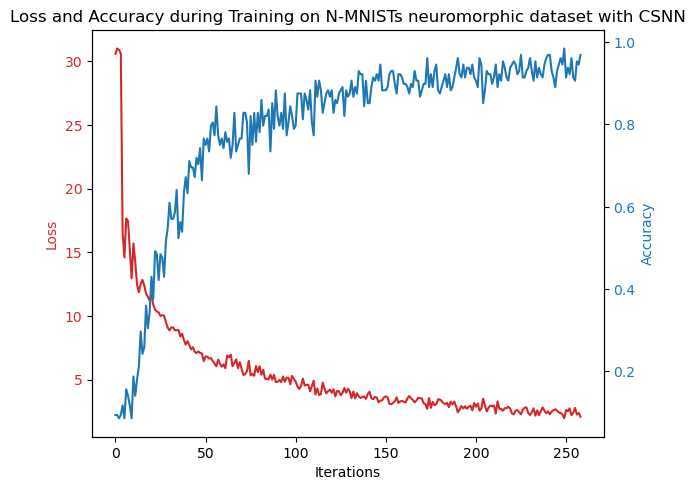

In [35]:
# plot loss and acc

import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Make the first plot: Loss values
color = 'tab:red'
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss', color=color)
ax1.plot(loss_hist, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  

# Make the second plot: Accuracy values
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(acc_hist, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # To make sure that the right y-label is not slightly clipped
plt.title('Loss and Accuracy during Training on N-MNISTs neuromorphic dataset with CSNN')
plt.show()

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize lists to store true labels and predictions
true_labels = []
predicted_labels = []

# Variables to store cumulative loss and correct predictions
cumulative_loss = 0.0
correct_predictions = 0
total_samples = 0

# Set the network to evaluation mode
net.eval()

# Set number of batches to evaluate on
num_batches_to_evaluate = 50  # You can adjust this number based on your needs

# Loop through the test data
for batch_idx, (data, targets) in enumerate(testloader):
    if batch_idx >= num_batches_to_evaluate:
        break
    data = data.to(device)
    targets = targets.to(device)

    with torch.no_grad():
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)
        cumulative_loss += loss_val.item() * data.size(0)  # Multiply by batch size to get total loss for this batch
    
    
    # Sum spikes over time and obtain class predictions
    summed_spikes = spk_rec.sum(dim=0)  # Summing over the time dimension
    
    # Get predicted classes
    predictions = torch.argmax(summed_spikes, dim=1)

    # Calculate the accuracy using SF.accuracy_rate and update the number of correct predictions
    acc = SF.accuracy_rate(spk_rec, targets)
    correct_predictions += acc * data.size(0)  # This assumes accuracy_rate returns a value between 0 and 1

    true_labels.extend(targets.cpu().numpy())
    predicted_labels.extend(predictions.cpu().numpy())
    total_samples += data.size(0)
    print(f"Batch {batch_idx+1}/{num_batches_to_evaluate}", end='\r')

# Calculate overall accuracy and loss
overall_accuracy = 100 * correct_predictions / total_samples
average_loss = cumulative_loss / total_samples

overall_accuracy = f"Overall Accuracy: {overall_accuracy:.2f}%"
overall_loss = f"Overall Loss: {average_loss:.4f}"
print(overall_accuracy)
print(overall_loss)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm, display_labels=range(cm.shape[0])).plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
ax.set_title(f'Confusion matrix of CSNN on N-MNISTs neuromorphic dataset\n{overall_accuracy}\n{overall_loss}')
plt.tight_layout()
plt.show()



In [ ]:
from IPython.display import HTML

idx = 0

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=1)

HTML(anim.to_html5_video())

In [17]:
# Save the model parameters (weights)
torch.save(net.state_dict(), 'neuro_csnn.pth')

In [ ]:
# First, initialize the model architecture
model = torch.load('neuro_csnn.pth')

# If using CUDA
model.to(device)
model.eval()


